<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
import nibabel as nib
from IPython.display import clear_output
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!apt-get install tree
!tree '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_jpg/'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (160 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_jpg/
├── BraTS20_Training_001
│   ├── BraTS20_Training_001_flair-slice077.jpg
│   ├── BraTS20_Training_001_seg-slice077.jpg
│   ├── BraTS20_Training_001_t1ce-slice077.jpg
│   ├── BraTS20_Training_001_t1-slice077.jpg
│   └── BraTS20_Tra

In [3]:
# Učitaj CSV datoteku
survival_info = pd.read_csv('/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData/survival_info.csv')
survival_info.head(5)

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


In [4]:
name_mapping = pd.read_csv('/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData/name_mapping.csv')
name_mapping.head(5)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [5]:
# Povezivanje podataka prema različitim ključevima
merged_data = pd.merge(name_mapping, survival_info, left_on="BraTS_2020_subject_ID", right_on="Brats20ID", how="inner")
merged_data.head(5)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID,Brats20ID,Age,Survival_days,Extent_of_Resection
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001,BraTS20_Training_001,60.463,289,GTR
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002,BraTS20_Training_002,52.263,616,GTR
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003,BraTS20_Training_003,54.301,464,GTR
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004,BraTS20_Training_004,39.068,788,GTR
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005,BraTS20_Training_005,68.493,465,GTR


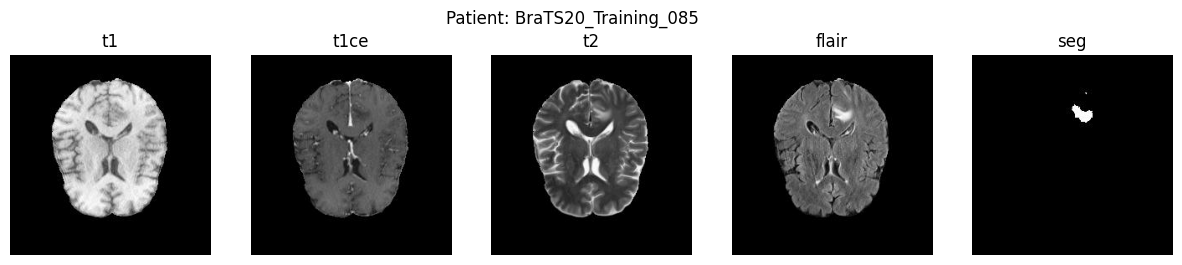

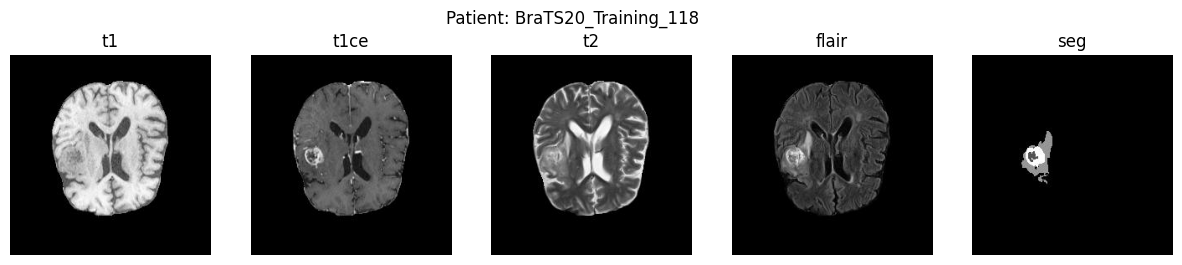

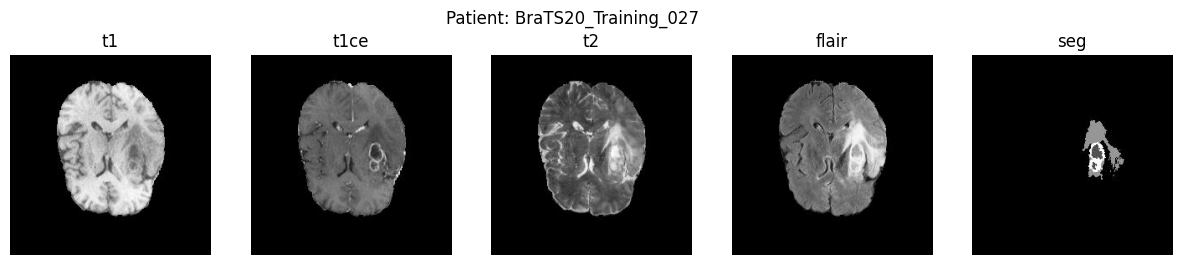

In [6]:
main_output_directory = '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_jpg/'

# Lista svih direktorija pacijenata u glavnom izlaznom direktoriju
patient_directories = [d for d in os.listdir(main_output_directory) if os.path.isdir(os.path.join(main_output_directory, d))]

# Nasumično odaberite 3 pacijenta
selected_patients = np.random.choice(patient_directories, size=3, replace=False)

# Funkcija za izdvajanje modality type iz naziva slike
def extract_modality_type(file_name):
    return file_name.split('_')[-1].split('-')[0]

# Prikazi slike za svakog odabrana pacijenta
for selected_patient in selected_patients:
    # Konstruiraj putanju do izlaznog direktorija odabranog pacijenta
    selected_patient_output_directory = os.path.join(main_output_directory, selected_patient)

    # Lista svih datoteka slika u izlaznom direktoriju odabranog pacijenta
    image_files = [f for f in os.listdir(selected_patient_output_directory) if f.endswith('.jpg')]

    # Sortiraj slike prema redoslijedu T1, T1CE, T2, FLAIR, seg
    image_files.sort(key=lambda x: ['t1', 't1ce', 't2', 'flair', 'seg'].index(extract_modality_type(x.lower())))

    # Prikazi svaku odabrane slike s povećanim razmakom
    plt.figure(figsize=(15, 3))
    for i, image_file in enumerate(image_files):
        # Izdvoji modality type pomoću funkcije
        modality_type = extract_modality_type(image_file)

        # Učitaj sliku
        img_path = os.path.join(selected_patient_output_directory, image_file)
        img = np.array(Image.open(img_path))

        plt.subplot(1, len(image_files), i + 1)
        plt.imshow(img, cmap='bone')
        plt.axis('off')
        plt.title(modality_type)

    plt.suptitle(f"Patient: {selected_patient}", fontsize=12)
    plt.show()


In [7]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Učitajte spojeni skup podataka
merged_data = pd.merge(name_mapping, survival_info, left_on="BraTS_2020_subject_ID", right_on="Brats20ID", how="inner")

# Postavite putanju do direktorija sa slikama
image_dir = '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_jpg/'

# Inicijalizirajte prazne liste za podatke i oznake
data = []
labels = []

for index, row in merged_data.iterrows():
    # Dobivanje ID-a pacijenta
    patient_id = row['BraTS_2020_subject_ID']

    # Konstruirajte putanju do direktorija pacijenta sa slikama
    patient_image_dir = os.path.join(image_dir, patient_id)

    # Provjerite jesu li poddirektoriji prisutni
    if os.path.isdir(patient_image_dir):
        try:
            # Učitajte slike i dodajte ih u podatke i oznake
            img_flair = np.array(Image.open(os.path.join(patient_image_dir, f'{patient_id}_flair-slice077.jpg')))
            img_t1 = np.array(Image.open(os.path.join(patient_image_dir, f'{patient_id}_t1-slice077.jpg')))
            img_t1ce = np.array(Image.open(os.path.join(patient_image_dir, f'{patient_id}_t1ce-slice077.jpg')))
            img_t2 = np.array(Image.open(os.path.join(patient_image_dir, f'{patient_id}_t2-slice077.jpg')))
            img_seg = np.array(Image.open(os.path.join(patient_image_dir, f'{patient_id}_seg-slice077.jpg')))

            # Dodajte slike u podatke i oznake
            data.append([img_flair, img_t1, img_t1ce, img_t2])
            labels.append(img_seg)

            # Ispis ID-a pacijenta ako je uspješno učitan
            print(f"Učitan pacijent: {patient_id}")

        except Exception as e:
            print(f"Greška pri učitavanju slika za pacijenta {patient_id}: {e}")

# Pretvorite liste u numpy nizove
data = np.array(data)
labels = np.array(labels)

# Provjerite dimenzije
print("Dimenzije skupa za učenje:", data.shape, labels.shape)

Učitan pacijent: BraTS20_Training_001
Učitan pacijent: BraTS20_Training_002
Učitan pacijent: BraTS20_Training_003
Učitan pacijent: BraTS20_Training_004
Učitan pacijent: BraTS20_Training_005
Učitan pacijent: BraTS20_Training_006
Učitan pacijent: BraTS20_Training_007
Učitan pacijent: BraTS20_Training_008
Učitan pacijent: BraTS20_Training_009
Učitan pacijent: BraTS20_Training_010
Učitan pacijent: BraTS20_Training_011
Učitan pacijent: BraTS20_Training_012
Učitan pacijent: BraTS20_Training_013
Učitan pacijent: BraTS20_Training_014
Učitan pacijent: BraTS20_Training_015
Učitan pacijent: BraTS20_Training_016
Učitan pacijent: BraTS20_Training_017
Učitan pacijent: BraTS20_Training_018
Učitan pacijent: BraTS20_Training_019
Učitan pacijent: BraTS20_Training_020
Učitan pacijent: BraTS20_Training_021
Učitan pacijent: BraTS20_Training_022
Učitan pacijent: BraTS20_Training_023
Učitan pacijent: BraTS20_Training_024
Učitan pacijent: BraTS20_Training_025
Učitan pacijent: BraTS20_Training_026
Učitan pacij

In [8]:
# Prikazivanje minimalnih i maksimalnih vrijednosti piksela u slikama
print("Min i Max vrijednosti prije normalizacije:")
print("Flair:", np.min(data[:, 0]), np.max(data[:, 0]))
print("T1:", np.min(data[:, 1]), np.max(data[:, 1]))
print("T1CE:", np.min(data[:, 2]), np.max(data[:, 2]))
print("T2:", np.min(data[:, 3]), np.max(data[:, 3]))
print("Segmentation:", np.min(labels), np.max(labels))

Min i Max vrijednosti prije normalizacije:
Flair: 0 255
T1: 0 255
T1CE: 0 255
T2: 0 255
Segmentation: 0 255


In [9]:
# Normalizacija na raspon [0, 1]
data_normalized = data / 255.0
labels_normalized = labels / 255.0

In [10]:
# Prikazivanje minimalnih i maksimalnih vrijednosti piksela u slikama
print("Min i Max vrijednosti prije normalizacije:")
print("Flair:", np.min(data_normalized[:, 0]), np.max(data_normalized[:, 0]))
print("T1:", np.min(data_normalized[:, 1]), np.max(data_normalized[:, 1]))
print("T1CE:", np.min(data_normalized[:, 2]), np.max(data_normalized[:, 2]))
print("T2:", np.min(data_normalized[:, 3]), np.max(data_normalized[:, 3]))
print("Segmentation:", np.min(labels_normalized), np.max(labels_normalized))

Min i Max vrijednosti prije normalizacije:
Flair: 0.0 1.0
T1: 0.0 1.0
T1CE: 0.0 1.0
T2: 0.0 1.0
Segmentation: 0.0 1.0


In [11]:
import torch
from torch.utils.data import Dataset

class BrainTumorDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {
            'image': self.data[idx],
            'mask': self.labels[idx]
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [12]:
# Primjer korištenja DataLoader-a
batch_size = 32
train_dataset = BrainTumorDataset(data_normalized, labels_normalized)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Kreiranje instance klase BraTSDataset
brats_dataset = BrainTumorDataset(data_normalized, labels_normalized)

# Prikazivanje nekoliko uzoraka iz dataseta
for i in range(5):
    sample = brats_dataset[i]
    print(f"Uzorak {i + 1}:")
    print("Dimenzije slike:", sample['image'].shape)
    print("Dimenzije maske:", sample['mask'].shape)
    print("--------------------------------------------------")

Uzorak 1:
Dimenzije slike: (4, 240, 240, 3)
Dimenzije maske: (240, 240, 3)
--------------------------------------------------
Uzorak 2:
Dimenzije slike: (4, 240, 240, 3)
Dimenzije maske: (240, 240, 3)
--------------------------------------------------
Uzorak 3:
Dimenzije slike: (4, 240, 240, 3)
Dimenzije maske: (240, 240, 3)
--------------------------------------------------
Uzorak 4:
Dimenzije slike: (4, 240, 240, 3)
Dimenzije maske: (240, 240, 3)
--------------------------------------------------
Uzorak 5:
Dimenzije slike: (4, 240, 240, 3)
Dimenzije maske: (240, 240, 3)
--------------------------------------------------
